Dans ce billet, je calcule la moyenne d'âge des députés français (c'est-à-dire les élus qui représentent les français à l'assemblée nationale, à ne pas confondre avec les sénateurs). Je me sers pour cela d'un document disponible sur le site de l'assemblée nationale, en PDF. J'en extrais les textes puis les traite afin de tracer un histogramme à l'aide du package d'analyse de données pour Python `pandas`.

# Introduction 

Pourquoi calculer l'âge moyen des députés ? Bonne question : l'idée m'est venue suite à la lecture de ce tweet.

<blockquote class="twitter-tweet" lang="en"><p lang="fr" dir="ltr">La moyennz d&#39;âge des députés et sénateurs français est de 65 ans ! STOP ! Place à la jeunesse !</p>&mdash; Geof&#39;☭ (@DebailleuxG) <a href="https://twitter.com/DebailleuxG/status/683281096822374401">January 2, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Comment savoir si ce qui est affirmé ici est vrai ou pas ? Je me concentre ici sur une réponse partielle : calculer l'âge moyen des députés et plus exactement leur distribution.

Ca tombe bien, car l'assemblée nationale met à disposition une liste alphabétique en PDF [ici](http://www2.assemblee-nationale.fr/static/tribun/trombinoscope/trombinoscope_alpha.pdf). Nous allons nous en servir pour calculer la distribution des âges. 

# Conversion du PDF en texte 

Il s'agit tout d'abord de convertir le fichier PDF en fichier texte brut. Je me sers ici de `pdftotext`, un utilitaire que l'on peut utiliser en ligne de commande.

In [1]:
!pdftotext.exe

pdftotext version 3.04
Copyright 1996-2014 Glyph & Cog, LLC
Usage: pdftotext [options] <PDF-file> [<text-file>]
  -f <int>             : first page to convert
  -l <int>             : last page to convert
  -layout              : maintain original physical layout
  -table               : similar to -layout, but optimized for tables
  -lineprinter         : use strict fixed-pitch/height layout
  -raw                 : keep strings in content stream order
  -fixed <fp>          : assume fixed-pitch (or tabular) text
  -linespacing <fp>    : fixed line spacing for LinePrinter mode
  -clip                : separate clipped text
  -enc <string>        : output text encoding name
  -eol <string>        : output end-of-line convention (unix, dos, or mac)
  -nopgbrk             : don't insert page breaks between pages
  -opw <string>        : owner password (for encrypted files)
  -upw <string>        : user password (for encrypted files)
  -q                   : don't print any messages or er

Après avoir lu l'aide, on peut convertir le fichier PDF en texte à l'aide de la commande suivante.

In [2]:
!pdftotext.exe trombinoscope_alpha.pdf

Comment s'appelle le fichier créé ?

In [3]:
!dir

 Le volume dans le lecteur C s'appelle Windows7
 Le num‚ro de s‚rie du volume est C299-2D6F

 R‚pertoire de C:\Users\FL232714\Documents\Perso\D‚put‚s

06/01/2016  13:25    <REP>          .
06/01/2016  13:25    <REP>          ..
06/01/2016  13:24    <REP>          .ipynb_checkpoints
06/01/2016  13:24                72 Analyse.ipynb
28/05/2014  11:50         1ÿ179ÿ648 pdftotext.exe
06/01/2016  13:22        16ÿ648ÿ365 trombinoscope_alpha.pdf
06/01/2016  13:25           155ÿ941 trombinoscope_alpha.txt
               4 fichier(s)       17ÿ984ÿ026 octets
               3 R‚p(s)  15ÿ229ÿ005ÿ824 octets libres


Lisons maintenant le fichier texte créé pour en extraire les noms des députés et les dates de naissance.


# Extraction du texte 

## Travail sur fragment 

Après avoir regardé le contenu du fichier texte au bloc note, je me suis rendu compte que les noms et dates de naissance sont dans le désordre. Pas de problème, on va lire ça avec des expressions régulières et on va voir si on arrive à trouver ce qu'on cherche ! On va travailler sur la première page dans un premier temps (on commence petit avant d'étendre la méthode au document entier) :

In [4]:
first_page = """Ain - Circonscription n° 5
M. Damien Abad

Val-de-Marne - Circonscription n° 6
Mme Laurence Abeille

Les Républicains Né le 5 avril 1980 à Nîmes (Gard) Secrétaire d'âge de l'Assemblée nationale
Président du conseil départemental (Ain) Élu à l'Assemblée nationale le 20 juin 2012
Mayotte - Circonscription n° 2
M. Ibrahim Aboubacar

Écologiste Née le 17 juin 1960 à Neuilly-sur-Seine (Hauts-de-Seine)
Cadre du secteur privé Élue à l'Assemblée nationale le 20 juin 2012
Hérault - Circonscription n° 6
M. Élie Aboud

Socialiste, républicain et citoyen Né le 1erfévrier 1965 à Fomboni (Comores)
Ingénieur des travaux publics Élu à l'Assemblée nationale le 20 juin 2012
Haute-Savoie - Circonscription n° 1
M. Bernard Accoyer

Les Républicains Né le 12 octobre 1959 à Beyrouth (Liban)
Médecin cardiologue (Chef de service) Adjoint au Maire de Béziers Élu à l'Assemblée nationale le 20 juin 2007 Réélu le 16 décembre 2012
Finistère - Circonscription n° 2
Mme Patricia Adam

Les Républicains Né le 12 août 1945 à Lyon (Rhône)

Socialiste, républicain et citoyen Née le 15 avril 1953 à Saint-Cloud (Hauts-de-Seine)

Médecin ORL
Maire d'Annecy-le-Vieux
Élu à l'Assemblée nationale le 28 mars 1993 Réélu les 1erjuin 1997, 16 juin 2002, 20 juin 2007 et 20 juin 2012

Cadre d'action sociale Élue à l'Assemblée nationale le 16 juin 2002 Réélue les 20 juin 2007 et 20 juin 2012

15"""

Construisons d'abord une expression régulière pour les prénoms :

In [5]:
import re

In [100]:
p = re.compile("^(M\.|Mme)((\s[\w\-]+)+)", re.MULTILINE)

In [101]:
p.findall(first_page)

[('M.', ' Damien Abad', ' Abad'),
 ('Mme', ' Laurence Abeille', ' Abeille'),
 ('M.', ' Ibrahim Aboubacar', ' Aboubacar'),
 ('M.', ' Élie Aboud', ' Aboud'),
 ('M.', ' Bernard Accoyer', ' Accoyer'),
 ('Mme', ' Patricia Adam', ' Adam')]

On peut maintenant passer aux dates de naissance :

In [102]:
p2 = re.compile('Né[e]* le (\d+(\s|er|eme)[a-z\u00E0-\u00FC]+ \d+)', re.MULTILINE)

In [103]:
p2.findall(first_page)

[('5 avril 1980', ' '),
 ('17 juin 1960', ' '),
 ('1erfévrier 1965', 'er'),
 ('12 octobre 1959', ' '),
 ('12 août 1945', ' '),
 ('15 avril 1953', ' ')]

L'expression régulière trouvée est un peu compliquée à cause de la présence de date écrite sous la forme `1er février`.

## Extraction du texte complet  

Maintenant que la première page donne des résultats valides, passons au texte complet.

In [104]:
text = open('trombinoscope_alpha.txt').read()

In [111]:
names = p.findall(text)
names

[('M.', ' Damien Abad', ' Abad'),
 ('Mme', ' Laurence Abeille', ' Abeille'),
 ('M.', ' Ibrahim Aboubacar', ' Aboubacar'),
 ('M.', ' Élie Aboud', ' Aboud'),
 ('M.', ' Bernard Accoyer', ' Accoyer'),
 ('Mme', ' Patricia Adam', ' Adam'),
 ('Mme', ' Sylviane Alaux', ' Alaux'),
 ('M.', ' Éric Alauzet', ' Alauzet'),
 ('M.', ' Yves Albarello', ' Albarello'),
 ('Mme', ' Brigitte Allain', ' Allain'),
 ('M.', ' Jean-Pierre Allossery', ' Allossery'),
 ('Mme', ' Nicole Ameline', ' Ameline'),
 ('M.', ' Pouria Amirshahi', ' Amirshahi'),
 ('M.', ' François André', ' André'),
 ('Mme', ' Sylvie Andrieux', ' Andrieux'),
 ('M.', ' Benoist Apparu', ' Apparu'),
 ('Mme', ' Nathalie Appéré', ' Appéré'),
 ('M.', ' Kader Arif', ' Arif'),
 ('Mme', ' Laurence Arribagé', ' Arribagé'),
 ('M.', ' François Asensi', ' Asensi'),
 ('M.', ' Christian Assaf', ' Assaf'),
 ('Mme', ' Isabelle Attard', ' Attard'),
 ('M.', ' Julien Aubert', ' Aubert'),
 ('M.', ' Olivier Audibert Troin', ' Troin'),
 ('Mme', ' Danielle Auroi', '

On voit que l'expression régulière fonctionne plutôt bien. Comptons le nombre de députés identifiés.

In [112]:
len(names)

577

On a le compte pour les noms ! Passons aux dates de naissance.

In [114]:
birthdates = p2.findall(text)
birthdates

[('5 avril 1980', ' '),
 ('17 juin 1960', ' '),
 ('1erfévrier 1965', 'er'),
 ('12 octobre 1959', ' '),
 ('12 août 1945', ' '),
 ('15 avril 1953', ' '),
 ('1erjuillet 1945', 'er'),
 ('7 juin 1958', ' '),
 ('17 mars 1952', ' '),
 ('23 avril 1956', ' '),
 ('31 juillet 1945', ' '),
 ('4 juillet 1952', ' '),
 ('27 mars 1972', ' '),
 ('19 juillet 1967', ' '),
 ('15 décembre 1961', ' '),
 ('24 novembre 1969', ' '),
 ('8 juillet 1975', ' '),
 ('3 juillet 1959', ' '),
 ('25 mai 1970', ' '),
 ('1erjuin 1945', 'er'),
 ('1erseptembre 1972', 'er'),
 ('14 novembre 1969', ' '),
 ('11 juin 1978', ' '),
 ('16 août 1960', ' '),
 ('29 février 1944', ' '),
 ('24 juillet 1942', ' '),
 ('25 janvier 1950', ' '),
 ('22 juillet 1961', ' '),
 ('19 août 1973', ' '),
 ('13 juillet 1974', ' '),
 ('11 mars 1949', ' '),
 ('24 octobre 1959', ' '),
 ('24 septembre 1946', ' '),
 ('16 août 1948', ' '),
 ('4 février 1946', ' '),
 ('30 août 1960', ' '),
 ('11 novembre 1960', ' '),
 ('6 novembre 1947', ' '),
 ('16 avril 19

In [115]:
len(birthdates)

577

On a aussi le compte pour les dates de naissance ! On peut mettre tout ça dans une dataframe Pandas.

# Analyse des données à l'aide de Pandas

Avant de pouvoir utiliser pandas pour faire des calculs de type Excel, il nous faut encore convertir les dates de naissance, qui sont du texte, vers des objets de type date. 

On va utiliser [`pd.Timestamp`](http://pandas.pydata.org/pandas-docs/stable/10min.html?highlight=timestamp) pour stocker les dates au bon format. On peut donner à l'objet Timestamp des chaînes de caractère en entrée, chose que nous allons faire.

In [116]:
import pandas as pd

In [130]:
pd.Timestamp('2012/5/1')

Timestamp('2012-05-01 00:00:00')

Nous pouvons écire la fonction ci-dessous :

In [161]:
def convert2date(date_str):
    d = {'janvier': 1, 'février': 2, 'mars': 3, 'avril': 4,
         'mai': 5, 'juin': 6, 'juillet': 7, 'août': 8, 
         'septembre': 9, 'octobre': 10, 'novembre': 11, 'décembre':12}
    splits = date_str.split(' ')
    if len(splits) != 3:
        start = splits.pop(0)
        if start.startswith('1er'):
            splits.insert(0, start[3:])
            splits.insert(0, '1')
    
    
    return pd.Timestamp(splits[2] + '/' + str(d[splits[1]]) + '/' + splits[0])
        

Testons notre fonction sur notre collection de dates de naissance. Nous sélectionnons ici seulement les dates qui commencent par le 3 du mois.

In [166]:
[b[0] for b in birthdates if b[0].startswith('3 ')]

['3 juillet 1959',
 '3 septembre 1963',
 '3 janvier 1966',
 '3 janvier 1973',
 '3 février 1948',
 '3 janvier 1940',
 '3 mars 1951',
 '3 août 1941',
 '3 janvier 1958',
 '3 février 1967',
 '3 août 1956',
 '3 décembre 1950',
 '3 août 1953',
 '3 mars 1940',
 '3 mai 1955',
 '3 mars 1949',
 '3 mai 1951',
 '3 août 1945',
 '3 août 1951',
 '3 janvier 1974',
 '3 janvier 1948',
 '3 janvier 1947',
 '3 février 1958']

Nous vérifions ci-dessous que les résultats sont pertinents :

In [167]:
[convert2date(b[0]) for b in birthdates if b[0].startswith('3 ')]

[Timestamp('1959-07-03 00:00:00'),
 Timestamp('1963-09-03 00:00:00'),
 Timestamp('1966-01-03 00:00:00'),
 Timestamp('1973-01-03 00:00:00'),
 Timestamp('1948-02-03 00:00:00'),
 Timestamp('1940-01-03 00:00:00'),
 Timestamp('1951-03-03 00:00:00'),
 Timestamp('1941-08-03 00:00:00'),
 Timestamp('1958-01-03 00:00:00'),
 Timestamp('1967-02-03 00:00:00'),
 Timestamp('1956-08-03 00:00:00'),
 Timestamp('1950-12-03 00:00:00'),
 Timestamp('1953-08-03 00:00:00'),
 Timestamp('1940-03-03 00:00:00'),
 Timestamp('1955-05-03 00:00:00'),
 Timestamp('1949-03-03 00:00:00'),
 Timestamp('1951-05-03 00:00:00'),
 Timestamp('1945-08-03 00:00:00'),
 Timestamp('1951-08-03 00:00:00'),
 Timestamp('1974-01-03 00:00:00'),
 Timestamp('1948-01-03 00:00:00'),
 Timestamp('1947-01-03 00:00:00'),
 Timestamp('1958-02-03 00:00:00')]

Nous pouvons maintenant fabriquer notre DataFrame avec l'ensemble des données :

In [199]:
df = pd.DataFrame(data=list(zip([n[1].split('\n')[0] for n in names], 
                           [convert2date(b[0]) for b in birthdates])), 
             columns=('Noms', 'Dates de naissance'))
df

,Noms,Dates de naissance
0,Damien Abad,1980-04-05
1,Laurence Abeille,1960-06-17
2,Ibrahim Aboubacar,1965-02-01
3,Élie Aboud,1959-10-12
4,Bernard Accoyer,1945-08-12
5,Patricia Adam,1953-04-15
6,Sylviane Alaux,1945-07-01
7,Éric Alauzet,1958-06-07
8,Yves Albarello,1952-03-17
9,Brigitte Allain,1956-04-23


Armé de cette dataframe, nous pouvons calculer l'âge des différents députés assez facilement :

In [200]:
import datetime

In [201]:
datetime.date.today()

datetime.date(2016, 1, 6)

In [202]:
df['Âge'] = pd.Timestamp(datetime.date.today()) - df['Dates de naissance'] 

In [203]:
df

,Noms,Dates de naissance,Âge
0,Damien Abad,1980-04-05,13059 days
1,Laurence Abeille,1960-06-17,20291 days
2,Ibrahim Aboubacar,1965-02-01,18601 days
3,Élie Aboud,1959-10-12,20540 days
4,Bernard Accoyer,1945-08-12,25714 days
5,Patricia Adam,1953-04-15,22911 days
6,Sylviane Alaux,1945-07-01,25756 days
7,Éric Alauzet,1958-06-07,21032 days
8,Yves Albarello,1952-03-17,23305 days
9,Brigitte Allain,1956-04-23,21807 days


Le problème, c'est que l'âge est en jours, on va donc [le convertir en années](http://stackoverflow.com/questions/16103238/pandas-timedelta-in-days) : 

In [204]:
df['Âge (années)'] = [x.days / 365 for x in df['Âge']]

In [205]:
df

,Noms,Dates de naissance,Âge,Âge (années)
0,Damien Abad,1980-04-05,13059 days,35.778082
1,Laurence Abeille,1960-06-17,20291 days,55.591781
2,Ibrahim Aboubacar,1965-02-01,18601 days,50.961644
3,Élie Aboud,1959-10-12,20540 days,56.273973
4,Bernard Accoyer,1945-08-12,25714 days,70.449315
5,Patricia Adam,1953-04-15,22911 days,62.769863
6,Sylviane Alaux,1945-07-01,25756 days,70.564384
7,Éric Alauzet,1958-06-07,21032 days,57.621918
8,Yves Albarello,1952-03-17,23305 days,63.849315
9,Brigitte Allain,1956-04-23,21807 days,59.745205


On peut maintenant faire un joli histogramme :

In [209]:
%matplotlib inline

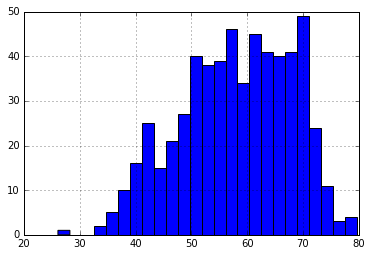

In [213]:
df['Âge (années)'].hist(bins=25)

Les statistiques que l'on peut calculer sont : 

In [211]:
df['Âge (années)'].describe()

count    577.000000
mean      57.993158
std        9.988493
min       26.090411
25%       50.961644
50%       58.621918
75%       66.161644
max       79.720548
Name: Âge (années), dtype: float64

# Comparaison avec le restant de la France 

On trouve sur le site de l'INSEE un lien vers des [statistiques sur l'âge de la population française en 2014](http://www.insee.fr/fr/themes/detail.asp?ref_id=bilan-demo&reg_id=0&page=donnees-detaillees/bilan-demo/pop_age2.htm).

In [317]:
df_pop = pd.read_excel('http://www.insee.fr/fr/ppp/bases-de-donnees/donnees-detaillees/bilan-demo/fichiers-xls/pop-1janvier-fm.xls',
                      skiprows=7,
                      header=1,
                      skipfooter=3)
df_pop

,Année de naissance,Âge révolu,Nombre d'hommes,Nombre de femmes,Ensemble
0,2014,0,387051,370260,757311
1,2013,1,387916,370500,758416
2,2012,2,394045,376249,770294
3,2011,3,394471,380218,774689
4,2010,4,407929,388696,796625
5,2009,5,405344,386586,791930
6,2008,6,407169,389524,796693
7,2007,7,405278,386970,792248
8,2006,8,412787,394049,806836
9,2005,9,404066,386640,790706


Le nombre de français par classe d'âge est le suivant : 

In [319]:
import matplotlib.pyplot as plt

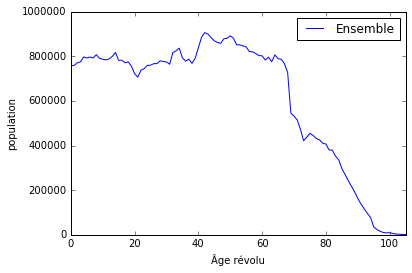

In [320]:
df_pop.plot('Âge révolu', 'Ensemble')
plt.ylabel('population')

Afin de pouvoir comparer la distribution des députés avec celle des français normaux, on va utiliser une méthode d'estimation par noyaux, analogue à un histogramme. Le code vient d'ici :

In [322]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

Afin d'utiliser ce code, il nous faut transformer les données cumulées disponibles pour la population française en données ponctuelles (une série d'âges). Nous faisons ceci en prenant une certaine classe d'âge proportionnellement à un facteur de décimation.

In [326]:
import numpy as np

In [332]:
decimation_factor = 1000
french_pop_ages = []
for ind, value in enumerate(df_pop['Ensemble']):
    french_pop_ages += [ind for _ in range(int(value / decimation_factor))]

In [334]:
len(french_pop_ages)

64152

On va faire les graphes sur des âges entre 0 et 100 ans. 

In [335]:
age_grid = np.linspace(0, 100)

In [357]:
pop_kde = kde_scipy(np.array(french_pop_ages), age_grid, bandwidth=0.4)
dep_kde = kde_scipy(df['Âge (années)'].values, age_grid, bandwidth=0.4)

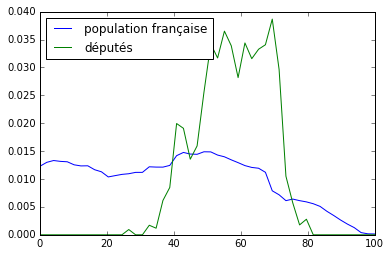

In [358]:
plt.plot(age_grid, 
         pop_kde, 
         label='population française')
plt.plot(age_grid, 
         dep_kde, 
         label='députés')
plt.legend(loc='upper left')

On peut également calculer un "taux de représentation à l'aide de ces valeurs :

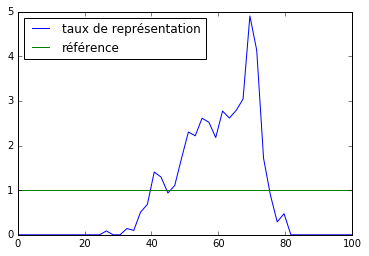

In [364]:
plt.plot(age_grid, dep_kde / pop_kde, label='taux de représentation')
plt.plot(age_grid, np.ones_like(age_grid), label='référence')
plt.legend(loc='upper left')

# Conclusions

Dans ce billet, nous avons étudié les données de l'âge disponibles pour les députés français. La distribution obtenue permet de retrouver les [histogrammes officiels](http://www.assemblee-nationale.fr/qui/xml/age.asp?legislature=14) et fournir de plus amples détails, comme par exemple la moyenne d'âge d'environ 60 ans des députés français. 

Dans la deuxième partie du billet, nous avons comparé la distribution des âges des députés avec celles du français moyen. On constate que les deux distributions sont assez différentes. En particulier, les jeunes (jusqu'à 40 ans environ) ne sont pas représentés dans les âges des députés, alors que les âges entre 50 et 70 sont surreprésentés (facteur entre 2 et 5). 

De nombreuses questions peuvent être posées au vu de ces résultats : quels sont les avantages et les inconvénients de cette distribution inégale ? Peut-on supposer qu'elle induit un biais significatif sur les décisions et les manières de penser par rapport à la population ? Existe-t-il des points sur lesquels l'expérience des députés diffère sensiblement de celle de la population (internet est un point qui me vient à l'esprit) ? Cette répartition par rapport à la population se retrouve-t-elle dans d'autres pays comparables à la France ? Comment a-t-elle évolué dans le temps (il y a 50 ans par exemple) ? 
